In [87]:
# Import basic libraries
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline
import os
import PIL
import PIL.Image
import keras

# Ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [88]:
DATA_DIR = 'D:\\Study\\DataScience\\GeoAI\\ImageClassification\\ImageSegmentation\\landcover'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [89]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['building', 'road', 'grass']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

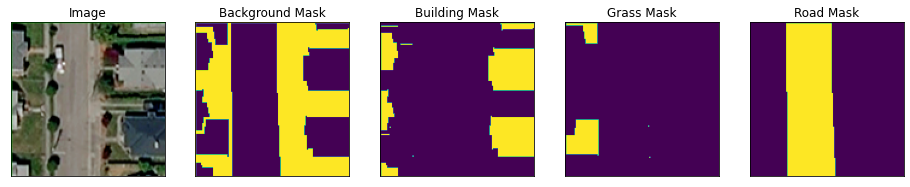

In [90]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['building', 'road', 'grass'])

image, mask = dataset[27] # get some sample
visualize(
    image=image, 
    background_mask=mask[..., 0].squeeze(),
    building_mask=mask[..., 1].squeeze(),
    grass_mask=mask[..., 2].squeeze(),
    road_mask=mask[..., 3].squeeze()  
)

In [91]:
import albumentations as A

In [101]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=128, min_width=128, always_apply=True, border_mode=0),
        A.RandomCrop(height=128, width=128, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

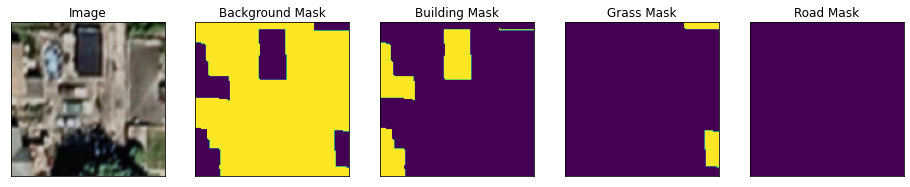

In [102]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['building', 'road', 'grass'], augmentation=get_training_augmentation())

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    background_mask=mask[..., 0].squeeze(),
    building_mask=mask[..., 1].squeeze(),
    grass_mask=mask[..., 2].squeeze(),
    road_mask=mask[..., 3].squeeze()
)

In [103]:
import segmentation_models as sm

In [104]:
BACKBONE = 'vgg16'
BATCH_SIZE = 8
CLASSES = ['building', 'road', 'grass']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [105]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [106]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
#dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
#focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
#total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss
total_loss = sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [107]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 128, 128, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 128, 128, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('effnet_Unet_dataaug.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [109]:
# Train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/40
3/3 [==============================] - 38s 13s/step - loss: 0.8427 - iou_score: 0.0572 - f1-score: 0.1049 - val_loss: 0.8442 - val_iou_score: 0.1411 - val_f1-score: 0.2141
Epoch 2/40
3/3 [==============================] - 30s 10s/step - loss: 0.8152 - iou_score: 0.0936 - f1-score: 0.1652 - val_loss: 0.8129 - val_iou_score: 0.1489 - val_f1-score: 0.2203
Epoch 3/40
3/3 [==============================] - 30s 10s/step - loss: 0.8096 - iou_score: 0.1088 - f1-score: 0.1866 - val_loss: 0.7939 - val_iou_score: 0.1535 - val_f1-score: 0.2235
Epoch 4/40
3/3 [==============================] - 30s 10s/step - loss: 0.8024 - iou_score: 0.1274 - f1-score: 0.2145 - val_loss: 0.7827 - val_iou_score: 0.1552 - val_f1-score: 0.2245
Epoch 5/40
3/3 [==============================] - 31s 10s/step - loss: 0.7856 - iou_score: 0.1542 - f1-score: 0.2507 - val_loss: 0.7768 - val_iou_score: 0.1571 - val_f1-scor

Text(0.5, 1.0, 'Accuracy Curves')

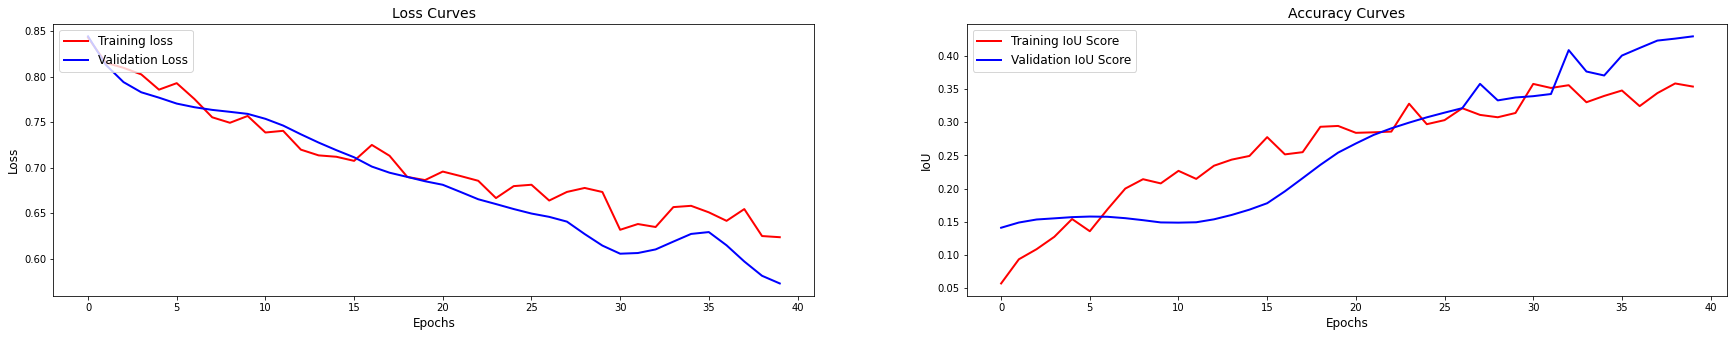

In [110]:
# Visualize Loss Curves
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['loss'],'r', linewidth=2.0)
plt.plot(history.history['val_loss'],'b', linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'], fontsize=12, loc='upper left')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Curves', fontsize=14)
  
# Visualize IoU Curves
plt.subplot(122)
plt.plot(history.history['iou_score'], 'r', linewidth=2.0)
plt.plot(history.history['val_iou_score'], 'b', linewidth=2.0)
plt.legend(['Training IoU Score', 'Validation IoU Score'], fontsize=12, loc='upper left')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('IoU', fontsize=12)
plt.title('Accuracy Curves', fontsize=14)